In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# prompt: navigate to my google drive

%cd /content/gdrive/MyDrive


/content/gdrive/MyDrive


In [3]:
cd fraud_detection_model/Data/

/content/gdrive/MyDrive/fraud_detection_model/Data


In [4]:
import pandas as pd
#df = pd.read_csv('creditcard.csv')

#get the above data from kaggle : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [5]:
#!pip install pandas-profiling sweetviz

In [6]:
#The Below code is commented because the report already exists in the drive


# import sweetviz as sv

# report = sv.analyze(df)
# report.show_html("sweetviz_report.html")

# Download the report
#files.download("sweetviz_report.html")

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

Class
0    284315
1       492
Name: count, dtype: int64
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458 

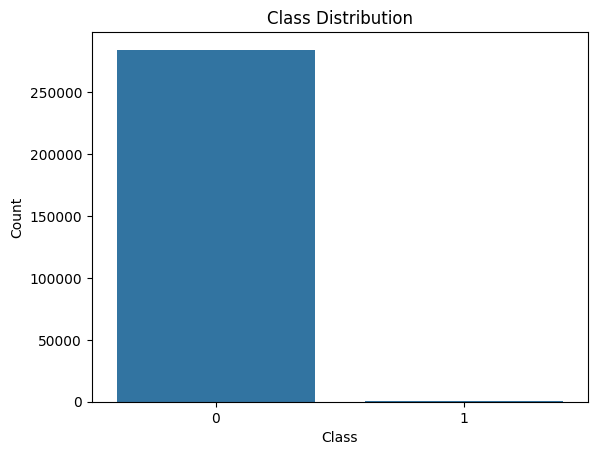

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
print(df["Class"].value_counts())

print(df.head())

#plot fraud vs non fraud
sns.countplot(x="Class", data=df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Expected Outcome: A huge imbalance in favor of Class 0 (non-fraud) ^



Since there is immense immabalance we are going to use

Two approaches:


1.   SMOTE
2.   Algorithmic adjustments

**SMOTE - Synthetic Minority Oversampling Technique**

**Oversampling Fraud Cases (SMOTE - Synthetic Minority Oversampling Technique)**

Instead of copying fraud cases, SMOTE generates new synthetic samples.
Helps prevent overfitting compared to naive oversampling.

**Undersampling Non-Fraud Cases**

Randomly remove some non-fraud cases to balance the dataset.
Risk: Losing valuable data from non-fraud cases.


note: We will use SMOTE because it preserves data balance without information loss

**Algorithmic adjustments**
Some ML models allow class weighing to penalize incorrect fraud predictions more than incorrect non-fraud ones.

eg:
1. Random forests and Logistic Regressions
2. XGBoost, we can tune scale_pos_weight (higher for fraud)



In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Class"])  # Features
y = df["Class"]                 # Target (labels)

#Train - Test split is 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Why Do We Split Into Training & Testing Data?
In machine learning, we need to evaluate how well our model generalizes to new data.

Training Set (X_train, y_train) → Used to train the model.
Test Set (X_test, y_test) → Used to evaluate the model on unseen data.

📌 Without a test set, we wouldn't know if our model truly works!


Why Use stratify=y in train_test_split()?
Since our dataset is highly imbalanced (only 0.172% fraud cases), we must ensure that both training & test sets have the same fraud-to-non-fraud ratio.


Stratify = y → Keeps the same class distribution in train & test sets.
Without stratification: The test set might have too few fraud cases, making evaluation unreliable.


In [9]:
#checking to see if the stratification actually worked

print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Test set class distribution:\n", y_test.value_counts(normalize=True))

Training set class distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [10]:
# Apply SMOTE to balance fraud cases
smote = SMOTE(sampling_strategy=0.5, random_state=42)
#FYI - Check notes on why we are using these parameters

x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print(pd.Series(y_train_resampled).value_counts())
print(pd.Series(y_train_resampled).value_counts(normalize=True))

Class
0    227451
1    113725
Name: count, dtype: int64
Class
0    0.666668
1    0.333332
Name: proportion, dtype: float64


We can see above that now after SMOTE, the distribution looks a lot more balanced than before

**Previously:**

Training set class distribution:

Class


*   0    | 0.998271

*   1    | 0.001729


**Now:**

Class
*   0   | 0.666668

*   1   | 0.333332



**Random Forest Model (why? check notes)**


In [11]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# import time

# #fit it on a non sampled data

# #Train Random Forest on the new balance dataset
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# start_time = time.perf_counter()
# rf_model.fit(x_train_resampled, y_train_resampled)
# end_time = time.perf_counter()


# print(f"Training time for rf model : {end_time - start_time:0.4f} seconds")


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

rf_model_2 = RandomForestClassifier(n_estimators=100, random_state=42)

#fit it on a non sampled data
#Train Random Forest on the new balance dataset, the difference is the data thats used
start_time = time.perf_counter()
rf_model_2.fit(X_train, y_train)
end_time = time.perf_counter()


print(f"Training time for rf model 2 with data without SMOTE : {end_time - start_time:0.4f} seconds")


Training time for rf model 2 with data without SMOTE : 241.3450 seconds


In [13]:
# from sklearn.metrics import classification_report


# print(classification_report(  y_test, rf_model.predict(X_test)))

In [14]:
from sklearn.metrics import classification_report


print(classification_report(  y_test, rf_model_2.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [15]:
# from sklearn.metrics import confusion_matrix

# confusion_matrix(y_test, rf_model.predict(X_test))

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, rf_model_2.predict(X_test))

array([[56859,     5],
       [   18,    80]])

In [17]:
#Train Random Forest on the new balance dataset
#flipping the weight to the minority
rf_model_3 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0:0.012, 1:0.998})
rf_model_3.fit(X_train, y_train)

KeyboardInterrupt: 

In [18]:
rf_model_2.feature_names_in_

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount'], dtype=object)

In [19]:
rf_model_2.feature_importances_

array([0.0130332 , 0.01533281, 0.01477529, 0.01952527, 0.03049632,
       0.00992157, 0.01345142, 0.02462713, 0.01256391, 0.03112673,
       0.07407348, 0.0452773 , 0.13332606, 0.01017516, 0.1363633 ,
       0.01188756, 0.07179221, 0.17032464, 0.02815625, 0.01036168,
       0.01295745, 0.01865555, 0.01226804, 0.00844332, 0.00830004,
       0.00788143, 0.01962397, 0.0129893 , 0.01026882, 0.01202077])

In [20]:
#{k:v for k,v in zip(rf_model_2.feature_names_in_, rf_model_2.feature_importances_)}

(pd.DataFrame({k:v for k,v in zip(rf_model_2.feature_names_in_, rf_model_2.feature_importances_)}, index=[0]).T).sort_values(by=0, ascending=False)

,0
V17,0.170325
V14,0.136363
V12,0.133326
V10,0.074073
V16,0.071792
V11,0.045277
V9,0.031127
V4,0.030496
V18,0.028156
V7,0.024627


Final analysis:

Based on the above analysis, though the data is highly skewed, after fitting the test and train on to random forest, we found that actual data without SMOTE performed better.

Also the above features V17, V14, V12 are the top three important features.

**DEPLOYMENT**

In [21]:
import joblib


# The model is already dumbped in the drive
# #save the trained Random forest model
# joblib.dump(rf_model_2, 'fraud_detection_model_rf.pkl')

#Load the model for testing
model = joblib.load('fraud_detection_model_rf.pkl')

print(model.predict([X_test.iloc[0]]))


[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [24]:
# #Predicton for first 300 entries
# for i in range(300):
#   print(model.predict([X_test.iloc[i]]))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
